In [1]:
import torch
import transformers
import numpy as np
import matplotlib
import os
from scipy import fftpack

In [2]:
submission_clips = np.load('raw_data/submission_data.npy',allow_pickle=True).item()
user_train = np.load('raw_data/user_train.npy',allow_pickle=True).item()

In [3]:
print("Dataset keys - ", submission_clips.keys())
print("Number of submission sequences - ", len(user_train['sequences']))

Dataset keys -  dict_keys(['sequences'])
Number of submission sequences -  1600


In [4]:
sequence_names = list(submission_clips["sequences"].keys())
sequence_key = sequence_names[0]
single_sequence = submission_clips["sequences"][sequence_key]["keypoints"]
print("Sequence name - ", sequence_key)
print("Single Sequence shape ", single_sequence.shape)
print(f"Number of Frames in {sequence_key} - ", len(single_sequence))

Sequence name -  0D2SPY7EPE05CRPC8DP0
Single Sequence shape  (1800, 3, 12, 2)
Number of Frames in 0D2SPY7EPE05CRPC8DP0 -  1800


In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc

rc('animation', html='jshtml')
 
# Note: Image processing may be slow if too many frames are animated.                
 
#Plotting constants
FRAME_WIDTH_TOP = 850
FRAME_HEIGHT_TOP = 850
 
M1_COLOR = 'lawngreen'
M2_COLOR = 'skyblue'
M3_COLOR = 'tomato'
 
PLOT_MOUSE_START_END = [(0, 1), (1, 3), (3, 2), (2, 0),        # head
                        (3, 6), (6, 9),                        # midline
                        (9, 10), (10, 11),                     # tail
                        (4, 5), (5, 8), (8, 9), (9, 7), (7, 4) # legs
                       ]
 
class_to_number = {s: i for i, s in enumerate(user_train['vocabulary'])}
 
number_to_class = {i: s for i, s in enumerate(user_train['vocabulary'])}
 
def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)
 
def set_figax():
    fig = plt.figure(figsize=(8, 8))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))
 
    ax = fig.add_subplot(111)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    return fig, ax
 
def plot_mouse(ax, pose, color):
    # Draw each keypoint
    for j in range(10):
        ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=3)
 
    # Draw a line for each point pair to form the shape of the mouse
 
    for pair in PLOT_MOUSE_START_END:
        line_to_plot = pose[pair, :]
        ax.plot(line_to_plot[:, 0], line_to_plot[
                :, 1], color=color, linewidth=1)
 
def animate_pose_sequence(video_name, seq, start_frame = 0, stop_frame = 100, skip = 0,
                          annotation_sequence = None):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
 
    image_list = []
    
    counter = 0
    if skip:
        anim_range = range(start_frame, stop_frame, skip)
    else:
        anim_range = range(start_frame, stop_frame)
    
    for j in anim_range:
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax = set_figax()
        plot_mouse(ax, seq[j, 0, :, :], color=M1_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=M2_COLOR)
        plot_mouse(ax, seq[j, 2, :, :], color=M3_COLOR)
        
        if annotation_sequence is not None:
            annot = annotation_sequence[j]
            annot = number_to_class[annot]
            plt.text(50, -20, annot, fontsize = 16, 
                   bbox=dict(facecolor=class_to_color[annot], alpha=0.5))
 
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j))
 
        ax.axis('off')
        fig.tight_layout(pad=0)
        ax.margins(0)
 
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani

In [21]:
import copy

def fft_filter(data):
    data = np.reshape(data, (data.shape[0], 2, 1))
    # Taken from scipy-lectures
    fft = fftpack.fftn(data)
    keep_fraction = 0.5
    fft2 = fft.copy()

    _, r, c = fft2.shape

    fft2[:,int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
    fft2[:,:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

    new_data = fftpack.ifftn(fft2).real
    new_data = np.squeeze(new_data)
    return new_data

def fill_holes(data):
    clean_data = copy.deepcopy(data)
    for m in range(3):
        holes = np.where(clean_data[0,m,:,0]==0)
        if not holes:
            continue
        for h in holes[0]:
            sub = np.where(clean_data[:,m,h,0]!=0)
            if(sub and sub[0].size > 0):
                clean_data[0,m,h,:] = clean_data[sub[0][0],m,h,:]
            else:
                return np.empty((0))
    
    for fr in range(1,np.shape(clean_data)[0]):
        for m in range(3):
            holes = np.where(clean_data[fr,m,:,0]==0)
            if not holes:
                continue
            for h in holes[0]:
                clean_data[fr,m,h,:] = clean_data[fr-1,m,h,:]
    
    for m in range(3):
        for kp in range(12):
            clean_data[:, m, kp, :] = fft_filter(clean_data[:, m, kp, :])
            
    return clean_data

Processing frame  0
Processing frame  200
Processing frame  400


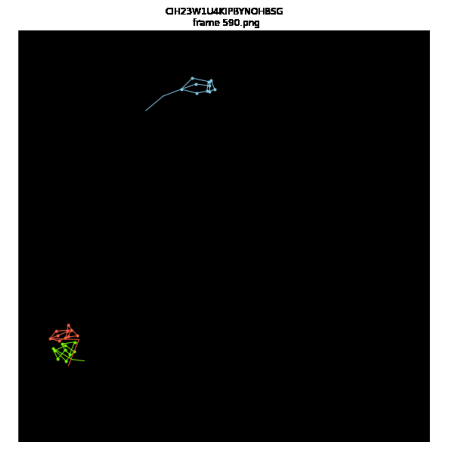

In [22]:
sequence_names = list(user_train['sequences'].keys())
sequence_key = sequence_names[1]
single_sequence = user_train["sequences"][sequence_key]


keypoint_sequence = single_sequence['keypoints']
filled_sequence = fill_holes(keypoint_sequence)
masked_data = np.ma.masked_where(keypoint_sequence==0, keypoint_sequence)

annotation_sequence = None  # single_sequence['annotations']

ani = animate_pose_sequence(sequence_key,
                            filled_sequence, 
                            start_frame = 0,
                            stop_frame = 600,
                            skip = 10,
                            annotation_sequence = annotation_sequence)

# Display the animaion on colab
ani

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed=42
seed_everything(seed)

In [ ]:
# generate the training data for PCA by stacking the entries of user_train
sequence_keys = list(user_train['sequences'].keys())
num_total_frames = np.sum([seq["keypoints"].shape[0] for _, seq in submission_clips['sequences'].items()])
sequence_dim = np.shape(user_train['sequences'][sequence_keys[0]]['keypoints'])
keypoints_dim = sequence_dim[1]*sequence_dim[2]*sequence_dim[3]

pca_train = np.empty((num_total_frames, keypoints_dim, 3), dtype=np.float32)
start = 0
for k in sequence_keys:
  keypoints = fill_holes(user_train['sequences'][k]["keypoints"])
  if keypoints.size == 0:  # sometimes a mouse is missing the entire time
    continue

  end = start + len(keypoints)
  for center_mouse in range(3):   # we're going to do PCA three times, each time centered on one mouse (rotating to mouse-eye-view and centering might be better...)
    ctr = np.median(keypoints[:,center_mouse,:,:],axis=1)
    ctr = np.repeat(np.expand_dims(ctr,axis=1),3,axis=1)
    ctr = np.repeat(np.expand_dims(ctr,axis=2), 12, axis=2)
    keypoints_centered = keypoints - ctr
    keypoints_centered = keypoints_centered.reshape(keypoints_centered.shape[0], -1)

    pca_train[start:end,:, center_mouse] = keypoints_centered
  start = end

In [ ]:
embed_size = 20
scaler_store = []
pca_store = []
for m in range(3):
  pca = PCA(n_components = embed_size)
  scaler = StandardScaler(with_std=False)
  scaler_store.append(scaler.fit(pca_train[:,:,m]))
  pca_store.append(pca.fit(pca_train[:,:,m]))

In [ ]:
num_total_frames = np.sum([seq["keypoints"].shape[0] for _, seq in submission_clips['sequences'].items()])
embeddings_array = np.empty((num_total_frames, embed_size*3), dtype=np.float32)

frame_number_map = {}
start = 0
for sequence_key in submission_clips['sequences']:
  keypoints = fill_holes(submission_clips['sequences'][sequence_key]["keypoints"])
  if keypoints.size == 0:
    keypoints = submission_clips['sequences'][sequence_key]["keypoints"]
  embeddings = np.empty((len(keypoints),embed_size*3), dtype=np.float32)

  for center_mouse in range(3):   # now apply our three PCA transformations to the test data
    ctr = np.median(keypoints[:,center_mouse,:,:],axis=1)
    ctr = np.repeat(np.expand_dims(ctr,axis=1),3,axis=1)
    ctr = np.repeat(np.expand_dims(ctr,axis=2), 12, axis=2)
    keypoints_centered = keypoints - ctr
    keypoints_centered = keypoints_centered.reshape(keypoints_centered.shape[0], -1)

    x = scaler_store[center_mouse].transform(keypoints_centered)
    embeddings[:,(center_mouse*embed_size):((center_mouse+1)*embed_size)] = pca_store[center_mouse].transform(x)

  end = start + len(keypoints)
  embeddings_array[start:end] = embeddings
  frame_number_map[sequence_key] = (start, end)
  start = end
  
assert end == num_total_frames
submission_dict = {"frame_number_map": frame_number_map, "embeddings": embeddings_array}

In [ ]:
# Input and Embeddings shape
print("Input shape:", submission_clips['sequences'][sequence_key]["keypoints"].shape)
print("Embedding shape:", embeddings.shape)